In [3]:
# 1. Kendi yazdığın kütüphaneyi GitHub'dan çekiyoruz (Burası çok havalı duracak makalede)
!pip install git+https://github.com/yusufkorkmazyigit/abc-optimizer-lib.git

# 2. MedMNIST kütüphanesi
!pip install medmnist

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO
import numpy as np
import copy
import matplotlib.pyplot as plt

# Cihaz ayarı (GPU varsa kullan)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

  Cloning https://github.com/yusufkorkmazyigit/abc-optimizer-lib.git to /tmp/pip-req-build-pdsjh_bk
  Running command git clone --filter=blob:none --quiet https://github.com/yusufkorkmazyigit/abc-optimizer-lib.git /tmp/pip-req-build-pdsjh_bk
  Resolved https://github.com/yusufkorkmazyigit/abc-optimizer-lib.git to commit db92c3424f8b8b7316cdcb30f028c248dc42d2b5
  Preparing metadata (setup.py) ... done
  Created wheel for abc_algorithm: filename=abc_algorithm-0.1.0-py3-none-any.whl size=4116 sha256=5a85ba2b395484f5909ed9fe79f534f3e3fd94b3aad6e17ce7c2dc9fc8718f82
  Stored in directory: /tmp/pip-ephem-wheel-cache-d56n8_2g/wheels/09/07/50/21e782018496d33c7d21b412a8f41c57b43498270febde0cb9
Successfully built abc_algorithm
Kullanılan Cihaz: cuda


In [5]:
import os

# 1. MedMNIST'in varsayılan klasörünü oluştur
!mkdir -p /root/.medmnist

# 2. Dosyayı 'wget' komutu ile zorla indir (Zenodo'dan doğrudan çekiyoruz)
print("Veri indiriliyor (wget ile)...")
!wget -O /root/.medmnist/pathmnist.npz "https://zenodo.org/records/10519652/files/pathmnist.npz?download=1"

# 3. İndirme başarılı mı kontrol et
if os.path.exists("/root/.medmnist/pathmnist.npz"):
    print("\n✅ Başarılı! Dosya /root/.medmnist/pathmnist.npz konumuna indirildi.")
    print("Şimdi bir önceki 'Data Pipeline' kod bloğunu tekrar çalıştırabilirsiniz.")
else:
    print("❌ İndirme başarısız oldu.")

Veri indiriliyor (wget ile)...
--2026-01-20 10:25:39--  https://zenodo.org/records/10519652/files/pathmnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.185.48.75, 188.185.43.153, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205615438 (196M) [application/octet-stream]
Saving to: ‘/root/.medmnist/pathmnist.npz’

/root/.medmnist/pat 100%[===================>] 196.09M  4.54MB/s    in 62s     

2026-01-20 10:26:41 (3.17 MB/s) - ‘/root/.medmnist/pathmnist.npz’ saved [205615438/205615438]


✅ Başarılı! Dosya /root/.medmnist/pathmnist.npz konumuna indirildi.
Şimdi bir önceki 'Data Pipeline' kod bloğunu tekrar çalıştırabilirsiniz.


In [6]:
def get_data_and_clients(data_flag='pathmnist', num_clients=5, non_iid_alpha=0.5):
    """
    MedMNIST verisini indirir ve Dirichlet dağılımı ile Non-IID olarak istemcilere böler.
    """
    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])

    # Ön İşleme
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])

    # Veriyi İndir
    train_dataset = DataClass(split='train', transform=data_transform, download=True)
    val_dataset = DataClass(split='val', transform=data_transform, download=True)
    test_dataset = DataClass(split='test', transform=data_transform, download=True)

    # --- Non-IID Dağıtım Mantığı ---
    # Dirichlet dağılımı kullanarak sınıf bazlı dengesizlik yaratıyoruz
    labels = train_dataset.labels.squeeze()
    n_classes = len(info['label'])
    label_list = [np.where(labels == i)[0] for i in range(n_classes)]

    client_indices = [[] for _ in range(num_clients)]

    for c in range(n_classes):
        # Her sınıf için dağılım oranlarını belirle
        proportions = np.random.dirichlet(np.repeat(non_iid_alpha, num_clients))
        # Sınıfın verilerini bu oranlara göre böl
        proportions = np.array([p * (len(idx_j) < len(train_dataset) / num_clients) for p, idx_j in zip(proportions, label_list)])
        proportions = proportions / proportions.sum()
        proportions = (np.cumsum(proportions) * len(label_list[c])).astype(int)[:-1]

        split_indices = np.split(label_list[c], proportions)
        for client_id, idx in enumerate(split_indices):
            client_indices[client_id] += idx.tolist()

    # İstemci Datasetlerini Oluştur
    client_datasets = [Subset(train_dataset, idx) for idx in client_indices]

    print(f"Veri Seti: {data_flag} | İstemci Sayısı: {num_clients} | Non-IID Alpha: {non_iid_alpha}")
    return train_dataset, val_dataset, test_dataset, client_datasets, info

# Veriyi Hazırla (PathMNIST: Bağırsak dokusu sınıflandırma - RGB)
train_data, val_data, test_data, client_datasets, info = get_data_and_clients(data_flag='pathmnist', num_clients=5)

Veri Seti: pathmnist | İstemci Sayısı: 5 | Non-IID Alpha: 0.5


In [7]:
class CNNModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Modeli test etme
n_channels = info['n_channels']
n_classes = len(info['label'])
temp_model = CNNModel(n_channels, n_classes).to(device)
print(f"Model Oluşturuldu: {n_channels} kanal giriş, {n_classes} sınıf çıkış.")

Model Oluşturuldu: 3 kanal giriş, 9 sınıf çıkış.


In [8]:
# 1. İstemci Eğitimi (Local Training)
def train_client(global_model, dataset, lr, momentum, local_epochs=1):
    model = copy.deepcopy(global_model)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    for epoch in range(local_epochs):
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device).squeeze().long()
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    return model.state_dict()

# 2. FedAvg (Ağırlık Ortalaması Alma)
def fed_avg(weights_list):
    w_avg = copy.deepcopy(weights_list[0])
    for k in w_avg.keys():
        for i in range(1, len(weights_list)):
            w_avg[k] += weights_list[i][k]
        w_avg[k] = torch.div(w_avg[k], len(weights_list))
    return w_avg

# 3. Validasyon Fonksiyonu (Modeli Test Etmek İçin)
def evaluate_model(model, dataset):
    model.eval()
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device).squeeze().long()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    avg_loss = total_loss / len(loader)
    return acc, avg_loss

In [11]:
# ==========================================
# GÜNCELLENMİŞ 4. BLOK (İLERLEMEYİ GÖSTEREN VERSİYON)
# ==========================================

from abc_algorithm import CanonicalABCSolver

# Sayaç için global değişken (Sadece görsel takip için)
counter = 0

def fl_objective_function(params):
    global counter
    counter += 1

    # Arı'nın önerdiği parametreler
    lr = params[0]
    momentum = params[1]

    # Ekrana ne denediğini yazdıralım
    print(f"🔍 Deneme {counter}: LR={lr:.4f}, Mom={momentum:.4f} deneniyor...", end="")

    # Mantıksız değerler gelirse
    if lr <= 0.0001 or momentum < 0 or momentum >= 1.0:
        print(" -> ❌ (Sınır dışı)")
        return 100.0

    # --- Simülasyon Başlıyor ---
    try:
        global_model = CNNModel(n_channels, n_classes).to(device)
        global_weights = global_model.state_dict()

        simulation_rounds = 3 # Hız için 3 tur

        for r in range(simulation_rounds):
            local_weights = []
            for client_dataset in client_datasets:
                w = train_client(global_model, client_dataset, lr, momentum, local_epochs=1)
                local_weights.append(w)

            global_weights = fed_avg(local_weights)
            global_model.load_state_dict(global_weights)

        _, val_loss = evaluate_model(global_model, val_data)

        # Sonucu yazdır
        print(f" -> ✅ Loss: {val_loss:.4f}")
        return val_loss

    except Exception as e:
        print(f" -> 💥 Hata: {e}")
        return 100.0

# --- Optimizasyonu Başlat ---
print("🐝 ABC Algoritması Hiperparametre Arıyor... (Loglar aşağıda akacak)")
counter = 0 # Sayacı sıfırla

solver = CanonicalABCSolver(
    objective_func=fl_objective_function,
    n_params=2,
    lb=[0.001, 0.0],
    ub=[0.1, 0.9],
    pop_size=10,
    max_evals=20 # 20 Deneme yapılacak
)

best_params, best_fitness, history = solver.solve()

opt_lr = best_params[0]
opt_mom = best_params[1]

print(f"\n✅ Bulunan En İyi Parametreler:\nLearning Rate: {opt_lr:.5f}\nMomentum: {opt_mom:.5f}")

🐝 ABC Algoritması Hiperparametre Arıyor... (Loglar aşağıda akacak)
🔍 Deneme 1: LR=0.0098, Mom=0.1086 deneniyor... -> ✅ Loss: 0.7686
🔍 Deneme 2: LR=0.0229, Mom=0.6366 deneniyor... -> ✅ Loss: 0.6149
🔍 Deneme 3: LR=0.0983, Mom=0.8008 deneniyor... -> ✅ Loss: 0.8637
🔍 Deneme 4: LR=0.0761, Mom=0.8659 deneniyor... -> ✅ Loss: 0.9066
🔍 Deneme 5: LR=0.0814, Mom=0.7946 deneniyor... -> ✅ Loss: 0.7939
🔍 Deneme 6: LR=0.0778, Mom=0.6849 deneniyor... -> ✅ Loss: 0.6305
🔍 Deneme 7: LR=0.0799, Mom=0.7043 deneniyor... -> ✅ Loss: 0.6872
🔍 Deneme 8: LR=0.0690, Mom=0.5734 deneniyor... -> ✅ Loss: 0.6024
🔍 Deneme 9: LR=0.0226, Mom=0.7307 deneniyor... -> ✅ Loss: 0.6395
🔍 Deneme 10: LR=0.0361, Mom=0.0877 deneniyor... -> ✅ Loss: 0.6311
🔍 Deneme 11: LR=0.0098, Mom=0.0000 deneniyor... -> ✅ Loss: 0.7699
🔍 Deneme 12: LR=0.0229, Mom=0.5192 deneniyor... -> ✅ Loss: 0.6414
🔍 Deneme 13: LR=0.0983, Mom=0.8007 deneniyor... -> ✅ Loss: 0.8744
🔍 Deneme 14: LR=0.0761, Mom=0.8324 deneniyor... -> ✅ Loss: 0.9306
🔍 Deneme 15: LR=0.


--- 1. Standart FedAvg ---
Eğitim Başladı: fedavg | LR: 0.0100 | Mom: 0.5000
Round 1/15 - Acc: 73.16%
Round 2/15 - Acc: 75.10%
Round 3/15 - Acc: 74.29%
Round 4/15 - Acc: 81.49%
Round 5/15 - Acc: 82.58%
Round 6/15 - Acc: 80.32%
Round 7/15 - Acc: 76.52%
Round 8/15 - Acc: 74.82%
Round 9/15 - Acc: 79.75%
Round 10/15 - Acc: 79.92%
Round 11/15 - Acc: 83.68%
Round 12/15 - Acc: 81.69%
Round 13/15 - Acc: 83.19%
Round 14/15 - Acc: 77.90%
Round 15/15 - Acc: 78.05%

--- 2. ABC Optimized FedAvg ---
Eğitim Başladı: fedavg | LR: 0.0690 | Mom: 0.5734
Round 1/15 - Acc: 34.60%
Round 2/15 - Acc: 61.85%
Round 3/15 - Acc: 78.68%
Round 4/15 - Acc: 77.26%
Round 5/15 - Acc: 78.62%
Round 6/15 - Acc: 80.19%
Round 7/15 - Acc: 77.60%
Round 8/15 - Acc: 82.28%
Round 9/15 - Acc: 78.05%
Round 10/15 - Acc: 83.87%
Round 11/15 - Acc: 77.40%
Round 12/15 - Acc: 86.38%
Round 13/15 - Acc: 75.22%
Round 14/15 - Acc: 82.77%
Round 15/15 - Acc: 85.28%

--- 3. Centralized Baseline ---
Eğitim Başladı: centralized | LR: 0.0100 | M

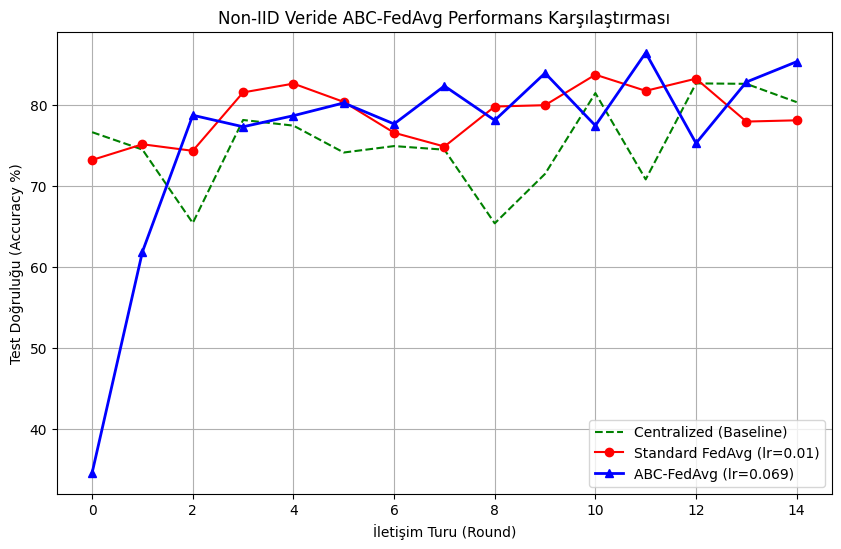

In [12]:
def run_full_training(mode='fedavg', lr=0.01, momentum=0.5, rounds=20):
    print(f"Eğitim Başladı: {mode} | LR: {lr:.4f} | Mom: {momentum:.4f}")

    model = CNNModel(n_channels, n_classes).to(device)
    global_weights = model.state_dict()

    acc_history = []

    if mode == 'centralized':
        # Baseline: Tek makinede klasik eğitim
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        criterion = nn.CrossEntropyLoss()
        loader = DataLoader(train_data, batch_size=32, shuffle=True)

        for r in range(rounds):
            model.train()
            for imgs, lbls in loader:
                imgs, lbls = imgs.to(device), lbls.to(device).squeeze().long()
                optimizer.zero_grad()
                loss = criterion(model(imgs), lbls)
                loss.backward()
                optimizer.step()

            acc, _ = evaluate_model(model, test_data)
            acc_history.append(acc)
            print(f"Round {r+1}/{rounds} - Acc: {acc:.2f}%")

    else:
        # Federated Learning
        for r in range(rounds):
            local_weights = []
            for client_dataset in client_datasets:
                w = train_client(model, client_dataset, lr, momentum, local_epochs=1)
                local_weights.append(w)

            global_weights = fed_avg(local_weights)
            model.load_state_dict(global_weights)

            acc, _ = evaluate_model(model, test_data)
            acc_history.append(acc)
            print(f"Round {r+1}/{rounds} - Acc: {acc:.2f}%")

    return acc_history

# --- DENEYLERİ ÇALIŞTIR ---
ROUNDS = 15 # Grafiklerin net çıkması için artırabilirsin (örn: 30-50)

# 1. Standart FedAvg (Rastgele parametreler)
print("\n--- 1. Standart FedAvg ---")
hist_std = run_full_training(mode='fedavg', lr=0.01, momentum=0.5, rounds=ROUNDS)

# 2. ABC-Optimized FedAvg (Senin Yöntemin)
print("\n--- 2. ABC Optimized FedAvg ---")
hist_abc = run_full_training(mode='fedavg', lr=opt_lr, momentum=opt_mom, rounds=ROUNDS)

# 3. Baseline (Merkezi - Üst Sınır Referansı)
print("\n--- 3. Centralized Baseline ---")
hist_central = run_full_training(mode='centralized', lr=0.01, momentum=0.5, rounds=ROUNDS)

# --- GRAFİK ÇİZ ---
plt.figure(figsize=(10, 6))
plt.plot(hist_central, 'g--', label='Centralized (Baseline)')
plt.plot(hist_std, 'r-o', label='Standard FedAvg (lr=0.01)')
plt.plot(hist_abc, 'b-^', linewidth=2, label=f'ABC-FedAvg (lr={opt_lr:.3f})')
plt.title('Non-IID Veride ABC-FedAvg Performans Karşılaştırması')
plt.xlabel('İletişim Turu (Round)')
plt.ylabel('Test Doğruluğu (Accuracy %)')
plt.legend()
plt.grid(True)
plt.show()

📊 Grafik 1: Veri Dağılımı Çiziliyor...


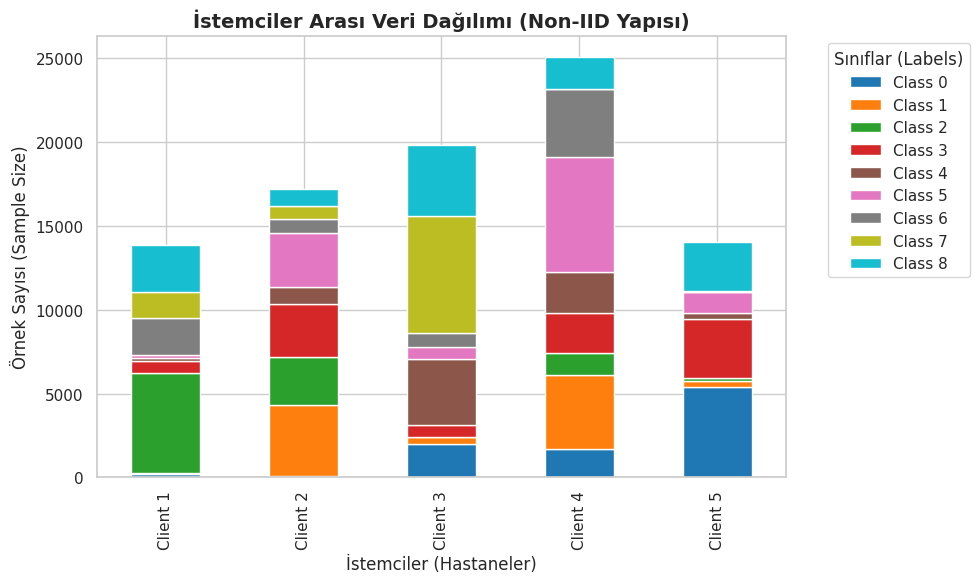


📈 Grafik 2: Trend Analizi Çiziliyor...


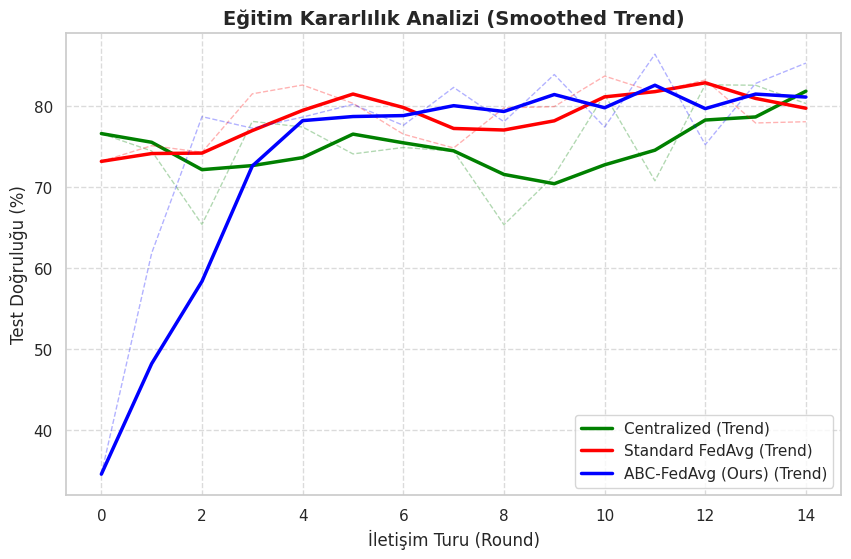


🏆 Grafik 3: Final Karşılaştırma Çiziliyor...


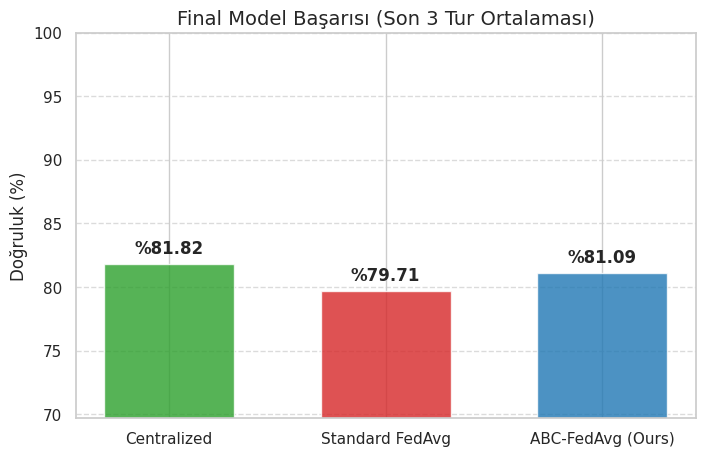

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Stil Ayarları (Makale kalitesi için)
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# ==========================================
# GRAFİK 1: Non-IID Veri Dağılımı (Heterojenlik Haritası)
# ==========================================
# Bu grafik, verinin hastaneler arasında ne kadar dengesiz dağıldığını kanıtlar.

def plot_client_distribution(client_datasets, num_classes=9):
    client_counts = {i: [0]*num_classes for i in range(len(client_datasets))}

    # Her istemcinin hangi sınıftan kaç verisi var sayalım
    for client_id, dataset in enumerate(client_datasets):
        # Subset olduğu için orijinal dataset üzerinden indeksleri alıyoruz
        labels = [dataset.dataset.labels[i].item() for i in dataset.indices]
        for label in labels:
            client_counts[client_id][label] += 1

    # DataFrame'e çevir
    df_dist = pd.DataFrame(client_counts).T
    df_dist.index = [f'Client {i+1}' for i in range(len(client_datasets))]
    df_dist.columns = [f'Class {i}' for i in range(num_classes)]

    # Çizim
    fig, ax = plt.subplots(figsize=(10, 6))
    df_dist.plot(kind='bar', stacked=True, colormap='tab10', ax=ax, edgecolor='white')

    plt.title('İstemciler Arası Veri Dağılımı (Non-IID Yapısı)', fontsize=14, fontweight='bold')
    plt.xlabel('İstemciler (Hastaneler)')
    plt.ylabel('Örnek Sayısı (Sample Size)')
    plt.legend(title='Sınıflar (Labels)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('non_iid_distribution.png', dpi=300)
    plt.show()

print("📊 Grafik 1: Veri Dağılımı Çiziliyor...")
# PathMNIST 9 sınıflıdır
plot_client_distribution(client_datasets, num_classes=9)


# ==========================================
# GRAFİK 2: Yumuşatılmış Performans Eğrisi (Trend Analizi)
# ==========================================
# Ham veriler bazen çok dalgalı görünür. Trendi göstermek için 'Rolling Mean' kullanılır.

def plot_smoothed_accuracy(histories, labels, colors, window=2):
    plt.figure(figsize=(10, 6))

    for hist, label, color in zip(histories, labels, colors):
        # Pandas ile hareketli ortalama (Rolling Window)
        series = pd.Series(hist)
        smooth = series.rolling(window=window, min_periods=1).mean()

        # Orijinal veriyi soluk, yumuşatılmış veriyi kalın çiz
        plt.plot(hist, color=color, alpha=0.3, linestyle='--', linewidth=1)
        plt.plot(smooth, color=color, label=f'{label} (Trend)', linewidth=2.5)

    plt.title('Eğitim Kararlılık Analizi (Smoothed Trend)', fontsize=14, fontweight='bold')
    plt.xlabel('İletişim Turu (Round)')
    plt.ylabel('Test Doğruluğu (%)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('smoothed_accuracy_trend.png', dpi=300)
    plt.show()

print("\n📈 Grafik 2: Trend Analizi Çiziliyor...")
histories = [hist_central, hist_std, hist_abc]
labels = ['Centralized', 'Standard FedAvg', 'ABC-FedAvg (Ours)']
colors = ['green', 'red', 'blue']

plot_smoothed_accuracy(histories, labels, colors, window=3)


# ==========================================
# GRAFİK 3: Final Performans Kıyaslaması (Bar Chart)
# ==========================================
# Son turun sonuçlarını net bir şekilde karşılaştırmak için.

def plot_final_comparison(histories, labels):
    # Son 3 turun ortalamasını alarak daha güvenilir bir "Final Skoru" elde edelim
    final_scores = [np.mean(h[-3:]) for h in histories]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, final_scores, color=['#2ca02c', '#d62728', '#1f77b4'], alpha=0.8, width=0.6)

    # Barların üzerine değerleri yaz
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'%{yval:.2f}',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.ylim(min(final_scores)-10, 100) # Alt sınırı biraz kırp ki fark belli olsun
    plt.title('Final Model Başarısı (Son 3 Tur Ortalaması)', fontsize=14)
    plt.ylabel('Doğruluk (%)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('final_comparison_bar.png', dpi=300)
    plt.show()

print("\n🏆 Grafik 3: Final Karşılaştırma Çiziliyor...")
plot_final_comparison(histories, labels)